The following script consists of a Python version of Andrew Ng Stanford Course 'Machine Learning' taught on the Coursera Platform
Note: All exercise data and structure are credited to Stanford University 

**Caveat:** Contrary to the modularity presented in Octave scripts and as I'm using Jupyter Notebooks for educational purposes we will implement the functions on the same notebook where we will call them

# Exercise 1 - Loading and Visualizing the Data

In [1]:
# Import numpy libraries to deal with matrixes and vectors
import numpy as np
# Import pandas do read data files
import pandas as pd
# Import matplotlib to plot data
import matplotlib.pyplot as plt

# Import math 
import math 

# Import scipy optimization function and image rotate function
from scipy import optimize, io
from scipy.ndimage import rotate

# Import linalg norm function
from numpy.linalg import norm

# Matplotlib notebook property
%matplotlib inline

In [2]:
# Use scipy Io to load matrix object
ex4_file = io.loadmat('ex4data1.mat')
X = np.array(ex4_file['X'])
y = np.array(ex4_file['y'])

print('# of training examples: {}'.format(len(X)))
m = len(X)

# of training examples: 5000


In [3]:
# Define Neural Network initial parameters

input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

Similar to exercise 3, this data translates some portion of the MNIST dataset, translating vector representations of handrwritten digits. 
The data is unrolled into a 400 dimensional vector with grayscales intensity. By reshaping the data below we are going to be able to clearly see the digits themselves.

**We are going to plot 100 random digits below.**

In [4]:
# Select 100 random indices between 0 and 4999 
index = np.random.choice(X.shape[0], 101, replace=False) 

# Subset Array elements to Plot - using index
sel = X[index]

In [5]:
def displayData(
    images: np.array, 
    figsize1: int, 
    figsize2: int
) -> None:
    '''
    Plot figsize1 by figsize2 grid of hand-written digit images.
    
    Args:
        images(np.array): array of image data;
        figsize1(int): vertical size of grid.
        fizsize2(int): horizontal size of grid.
    Returns:
        None
    '''
    fig=plt.figure(figsize=(figsize1, figsize2))
    columns = figsize1
    rows = figsize2
    #Loop through each piece of the grid and plot the digit by reshaping the data into 20 by 20 pixel image
    for i in range(0, images.shape[0]-1):
        img = images[i-1].reshape(20,20)
        if i > sel.shape[0]:
            pass
        else:
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(rotate(img[::-1],270))
            plt.axis('off')
    plt.show()

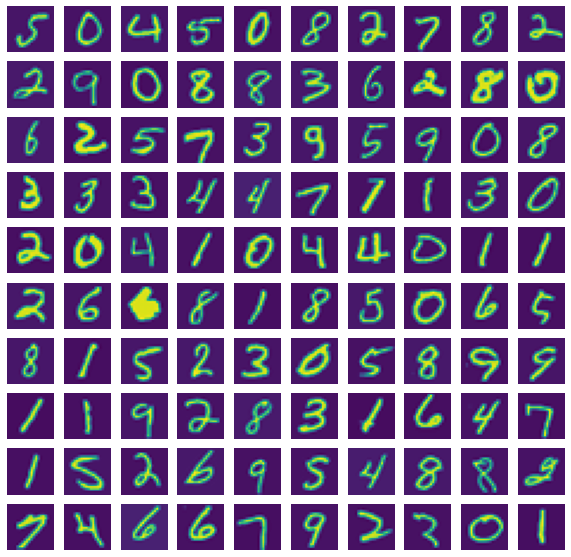

In [6]:
# Display the Grid
displayData(sel,10,10)

We want to develop a multi-class classification with a Neural Network. In the previous exercise we got the pre-trained weights and implemented a Neural Network with those values. We are now going to optimize these pre-trained weights by using a combination of gradient descent and cost function for each neural network with a techique called backpropagation.

# Exercise 1 - Neural Network Development - Cost Computation

<b>Remembering the architecture of a Neural Network:

<img src="assets/NeuralNetwork.JPG">

In [7]:
# Loading the initial weights from pre-trained Neural Network
ex4_weights = io.loadmat('ex4weights.mat')

# Unroll the Neural Network parameters into a single column vector
nn_params = np.append(ex4_weights['Theta1'].ravel(),ex4_weights['Theta2'].ravel())

nn_params = nn_params.reshape(len(nn_params),1)

A feed forward Neural Network will compute the cost sequentially through all the Neural Network layers. 
Remember that the cost function for single or multiple targets is:

<img src="assets/CostFunctionNN.JPG">

And the regularized version:

<img src="assets/CostFunctionNNRegul.JPG">

<b>Recall that higher lambda values increase the penalization on model parameters, therefore, reducing overfitting.

In Neural Networks, one of the ways we optimize the cost function by computing the error from the output layer until the input layer. This method is called backpropagation.

<img src="assets/BackpropagationNN.JPG">

In [8]:
# Define sigmoid function 
def sigmoid(
    x: np.array
)-> np.array:
    '''
    Outputs the Sigmoid for each element of an array.
    
    Args:
        x(np.array): original value of each feature
    Returns:
        (np.array): sigmoid values of array x    
    '''
    return(1 / (1 + np.exp(-x)))

In [9]:
# Define Lambda - regularization parameters
lambdas = 0

In [35]:
#Defining the Neural Network cost function and gradient: 

def nnCostFunction(
    nn_params: np.array, 
    input_layer_size: int, 
    hidden_layer_size: int, 
    num_labels: int,
    X: np.array, 
    y: np.array, 
    lambdas: float
):    
    '''
    Computes cost function and gradient for Neural Network
    using backpropagation. 
    The architecture of this network consists of:
        - 1 input layer;
        - 1 hidden layer;
        - 1 output layer;
    Args:
        nn_params(np.array): initial_thetas
        input_layer_size(int): size of input layer
        hidden_layer_size(int): size of hidden layer
        num_labels(int): size of output layer
        X(np.array): original feature array
        y(np.array): target values for each observation
        lambdas(float): regularization parameter
    Returns:
        J(np.array): Value of cost function 
        grad.flatten()(np.array): Flatten array of gradient
    '''
    
    # Reshape Theta1 and Theta2 to it's original size
    Theta1 = nn_params[0:(input_layer_size+1) * hidden_layer_size].reshape(hidden_layer_size,input_layer_size+1)
    
    Theta2 = nn_params[((input_layer_size+1) * hidden_layer_size):].reshape(num_labels,hidden_layer_size+1)

    m = len(X)
    
    #Add bias term to X - input 
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X))
    
    # Initialize cost function
    J = 0  
    
    # Initialize gradient
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    y_real = np.zeros([num_labels,m])
    
    # Correctly assign Labels
    
    for i in range(1,num_labels+1):
        y_real[i-1,:] = (y==i).reshape(len(y),)
    
    # Compute cost function for all rows using a loop
    for t in range(0,m):
        
        # Hidden layer Calculations
        a1 = X_extended[t,:]
        z1 = np.dot(Theta1, a1.T)
        a2 = sigmoid(z1)
        # Add intercept to hidden layer output
        a2 = np.append(1,a2)
        # Output Layer Calculation
        z2 = np.dot(Theta2, a2.T)
        hypothesis = sigmoid(z2)
        # Update cost function
        J = J+sum((-y_real[:,t]*np.log(hypothesis) - (1-y_real[:,t])*np.log((1-hypothesis))))
        # Backpropagation Deltas - Hidden Layer backpropagation
        delta3 = hypothesis - y_real[:,t]
        # Applying reshapes on the next gradient as we want to use the inner 1 dimension for matrix multiplication
        Theta2_grad = Theta2_grad + np.dot(delta3.reshape(len(delta3),1),a2.reshape(1,len(a2)))
        # Backpropagation Deltas - Input Layer backpropagation
        delta2 = np.dot(Theta2.T,delta3) * (a2*(1-a2))
        Theta1_grad = Theta1_grad + np.dot(delta2[1:].reshape(len(delta2[1:]),1),a1.reshape(1, len(a1)))
    
    # Propagate error and gradients over every row
    J = J/m
    
    Theta1_grad = Theta1_grad / m
    Theta2_grad = Theta2_grad / m
    
    # Apply regularization to the Cost Function
    J = J + ((lambdas / (2*m)) * ((Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum()))
    Theta1_grad = Theta1_grad + (lambdas / m) * np.hstack((np.zeros([Theta1.shape[0], 1]), Theta1[:,1:]))
    Theta2_grad = Theta2_grad + (lambdas / m) * np.hstack((np.zeros([Theta2.shape[0], 1]), Theta2[:,1:]))
    # Unroll Gradients
    grad = np.append(Theta1_grad.ravel('F'),Theta2_grad.ravel('F'))
    grad = grad.reshape(len(grad),1)
    
    return J, grad.flatten()

In [11]:
#Defining the Neural Network cost function for Debugging: 

def nnCostFunctionDebug(
    nn_params: np.array, 
    input_layer_size: int, 
    hidden_layer_size: int, 
    num_labels: int,
    X: np.array, 
    y: np.array, 
    lambdas: int
):    
    '''
    Computes cost function and gradient for Neural Network
    using backpropagation. 
    The architecture of this network consists of:
        - 1 input layer;
        - 1 hidden layer;
        - 1 output layer;
    Args:
        nn_params(np.array): initial_thetas
        input_layer_size(int): size of input layer
        hidden_layer_size(int): size of hidden layer
        num_labels(int): size of output layer
        X(np.array): original feature array
        y(np.array): target values for each observation
        lambdas(float): regularization parameter
    Returns:
        J(np.array): Value of cost function 
        grad.flatten()(np.array): Flatten array of gradient
    '''
    
    # Reshape Theta1 and Theta2 to it's original size
    Theta1 = nn_params[0:(input_layer_size+1) * hidden_layer_size].reshape(hidden_layer_size,input_layer_size+1, order='F')
    Theta2 = nn_params[((input_layer_size+1) * hidden_layer_size):].reshape(num_labels,hidden_layer_size+1, order='F')
    
    m = len(X)
    # Add bias term to X - input 
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X))
    
    # Initialize cost function
    J = 0  
    # Initialize gradient
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    y_real = np.zeros([num_labels,m])
    # Correctly assign Labels
    for i in range(1,num_labels+1):
        y_real[i-1,:] = (y==i).reshape(len(y),)
    # Compute cost function for all rows using a loop
    for t in range(0,m):  
        # Hidden layer Calculations
        a1 = X_extended[t,:]
        z1 = np.dot(Theta1, a1.T)
        a2 = sigmoid(z1)
        # Add intercept to hidden layer output
        a2 = np.append(1,a2)
        # Output Layer Calculation
        z2 = np.dot(Theta2, a2.T)
        hypothesis = sigmoid(z2)
        # Update cost function
        J = J+sum((-y_real[:,t]*np.log(hypothesis) - (1-y_real[:,t])*np.log((1-hypothesis))))
        # Backpropagation Deltas - Hidden Layer backpropagation
        delta3 = hypothesis - y_real[:,t]
        # Applying reshapes on the next gradient as we want to use the inner 1 dimension for matrix multiplication
        Theta2_grad = Theta2_grad + np.dot(delta3.reshape(len(delta3),1),a2.reshape(1,len(a2)))
        # Backpropagation Deltas - Input Layer backpropagation
        delta2 = np.dot(Theta2.T,delta3) * (a2*(1-a2))
        Theta1_grad = Theta1_grad + np.dot(delta2[1:].reshape(len(delta2[1:]),1),a1.reshape(1, len(a1)))
    # Ponderate error and gradients over every row
    J = J/m    
    Theta1_grad = Theta1_grad / m
    Theta2_grad = Theta2_grad / m
    # Apply regularization to the Cost Function
    J = J + ((lambdas / (2*m)) * ((Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum()))
    Theta1_grad = Theta1_grad + (lambdas / m) * np.hstack((np.zeros([Theta1.shape[0], 1]), Theta1[:,1:]))
    Theta2_grad = Theta2_grad + (lambdas / m) * np.hstack((np.zeros([Theta2.shape[0], 1]), Theta2[:,1:]))
    # Unroll Gradients
    grad = np.append(Theta1_grad.ravel('F'),Theta2_grad.ravel('F'))
    grad = grad.reshape(len(grad),1)
    
    return J, grad.flatten()

In [12]:
# Compute cost function and regularization
J, grad = nnCostFunction(nn_params, input_layer_size, 
                  hidden_layer_size, num_labels,
                  X, y, lambdas)

In [13]:
print('Cost function for lambda = 0 is {0:.3g}'.format(J))

Cost function for lambda = 0 is 0.288


In [14]:
# Testing the same for higher regularization
J_lambda_1, lambda_grad_1 = nnCostFunction(nn_params, input_layer_size, 
                  hidden_layer_size, num_labels,
                  X, y, 1)

In [15]:
print('Cost function for lambda = 1 is {0:.3g}'.format(J_lambda_1))

Cost function for lambda = 1 is 0.384


# Exercise 2 - Backpropagation

We will start by implementing the function to calculate the sigmoid gradient. Recall that the gradient has the following formula:

<img src="assets/SigmoidGradient.JPG">

In [16]:
def sigmoidGradient(
    z: np.array
): 
    '''
    Calculates sigmoid activation for backpropagation
    Args:
        z(np.array): original values of z
    Returns:
        (np.array): gradient value of sigmoid gradient
    '''
    return sigmoid(z)*(1-sigmoid(z))

In [17]:
g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))

In [18]:
print('Sigmoid gradient evaluated at [-1, -0.5, 0, 0.5, 1]: {}'.format(np.round(g,3)))

Sigmoid gradient evaluated at [-1, -0.5, 0, 0.5, 1]: [0.197 0.235 0.25  0.235 0.197]


**First we will use a method to test our neural network backpropagation implementation by two methods.**

In [36]:
# We are initializing the Neural Network parameters randomly. 
def randInitializeWeights(
    L_in: int, 
    L_out: int
) -> np.array:
    '''
    Randomly initializes Neural Network weights.
    Args:
        L_in(int): input layer size of random initialization
        L_out(int): output layer size of random initialization
    Returns:
        W(np.array): random initialized weights
    '''
    epsilon_init = 0.12
    W = np.random.rand(L_in, 1+L_out) * 2 * epsilon_init - epsilon_init
    
    return W

In [37]:
# Generate initial weights for Theta 1 and Theta 2
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

In [38]:
# Unroll the random Neural Network parameters into a single column vector
initial_nn_params =np.append(initial_Theta1.ravel(),initial_Theta2.ravel())
initial_nn_params = initial_nn_params.reshape(len(initial_nn_params),1)

After completing the weight initialization, we will use a gradient checking function to validate the implementation.

In [39]:
def debugInitializeWeights(
    fan_out: int, 
    fan_in: int
) -> np.array:
    '''
    Initialize the weights with fan_in size 
    and fan_out output size.
    This function will be used further in the debugging
    on the neural network.
    
    Args:
        fan_out(int): Size of output layer.
        fan_in(int): Size of input layer.
    Returns:
        W(np.array): Weights of initialized neural network.    
    '''
    
    W = np.zeros([fan_out, 1 + fan_in])
    # We need to use order ='F' to keep the same format as Octave reshaping
    W = np.sin(np.arange(1,W.size+1)).reshape(W.shape, order='F')/10
    return W

def computeNumericalGradient(
    J: callable, 
    theta: np.array, 
    input_layer_size: int, 
    hidden_layer_size: int, 
    num_labels: int,
    X: np.array, 
    y: np.array, 
    lambdas: float
)-> np.array:
    
    '''
    Computes numerical gradient using "finite differences" and gives us a numerical estimation 
    of the gradient.
    
    Args:
        J(callable): Cost and gradient callable function.
        theta(np.array): Theta array.
        input_layer_size(int): Size of input layer.
        hidden_layer_size(int): Size of hidden layer.
        num_labels(int): Number of labels/target
        X(np.array): X features.
        y(np.array): target values.
        lambdas(float): regularization parameters.
    '''
    theta = theta.reshape(theta.shape[0],1, order='F')
    
    numgrad = np.zeros(theta.shape[0])
    perturb = np.zeros(theta.shape[0])
    
    e = 1e-4
    
    for i in range(0,len(theta)):
        perturb[i] = e
        loss1 = J((theta - perturb.reshape(len(theta),1)), input_layer_size, hidden_layer_size, num_labels, X, y, lambdas)
        loss2 = J((theta + perturb.reshape(len(theta),1)), input_layer_size, hidden_layer_size, num_labels, X, y, lambdas)
        #Compute Numerical Gradient
        numgrad[i] = (loss2[0]-loss1[0])/ (2*e)
        perturb[i] = 0
    
    return numgrad.flatten()

def checkNNGradients(
    lambdas: float
) -> None:
    '''
    Creates a small neural network and compares
    the gradients created by two methods. 
    The final print should be a really small value.
    
    Args:
        lambdas(float): Regularization Parameter
    Returns:
        None
    '''
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);
    
    #Generate fake data X and y
    
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = 1+np.mod(np.arange(0,m+1),3)[1:]

    #Unroll the random Neural Network parameters into a single column vector
    nn_params = np.append(Theta1.ravel(),Theta2.ravel())
    
    #Original nn_params_object 
    nn_params_orig = np.append(Theta1.ravel('F'),Theta2.ravel('F'))
    
    #Unroll the random Neural Network parameters into a single vector with different order
    nn_params = nn_params.reshape(len(nn_params),1)
    
    cost,grad = nnCostFunction(nn_params, input_layer_size, 
                  hidden_layer_size, num_labels,
                  X, y, lambdas)
    numgrad = computeNumericalGradient(nnCostFunctionDebug, nn_params_orig, input_layer_size, 
                  hidden_layer_size, num_labels,
                  X, y, lambdas)
    
    diff = norm(numgrad-grad)/norm(numgrad+grad)
    
    print('If the backpropagation implementation is correct then the relative difference between the gradients should be really, really small (less than 0.00000001). The diff is {}'.format(diff))

In [40]:
# Checking Neural Network Gradients - This method enables us
# to check the correct implementation of the backpropagation algorithm
checkNNGradients(0)

If the backpropagation implementation is correct then the relative difference between the gradients should be really, really small (less than 0.00000001). The diff is 2.4953296035240723e-11


Now, we are going to use scipy optimize to train the entire Neural Network. We will use 10 iterations to find the minimum value of the cost function - minimizing the error.

In [26]:
lambdas = 1

res = optimize.minimize(nnCostFunctionDebug, nn_params, 
               method='BFGS', args=(input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambdas), jac=True, options={'maxiter': 10,  "disp":True})


         Current function value: 1.461544
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


In [27]:
nn_params_optimization = res.x
cost = res.fun

# Obtain the optimized thetas
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [29]:
#Checking cost function after optimizing the Neural Network - After 10 iterations
cost

1.4615440704036637

One of the cool ways to visualize the effects of a Neural Network is to look at the effects on the hidden layer(s). <br>
Visualizing the  first Thetas (weights) shows some interesting features that the NN is trying to learn.

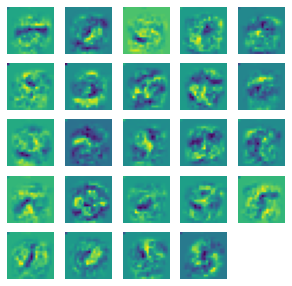

In [41]:
# Displaying the hidden layer thetas
displayData(Theta1[:,:400],5,5)

In [42]:
# Define predict function
def predict(
    Theta1: np.array, 
    Theta2: np.array, 
    X: np.array
)-> np.array:
    '''
    Outputs the maximum class predicted by the Neural Network
    Returns array of predicted digits
    Args:
        Theta1(np.array): Set of weights for hidden layer.
        Theta2(np.array): Set of weights for output layer.
        X(np.array): Observation values 
    Returns: 
        (np.array): Set of integers with predicted values.
    '''
    m = X.shape[0]

    # Add intercept
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X))
    
    staging_1 = sigmoid(np.dot(X_extended,Theta1.T))
    
    # Add ones to Staging_1 table
    ones_vector = np.ones((len(X),1))
    staging_1 = np.hstack((ones_vector,staging_1))
    
    staging_2 = sigmoid(np.dot(staging_1, Theta2.T))
    
    # We'll use idxmax to get the maximum probability assign to each row - add One to get the real digit
    prediction = pd.DataFrame(staging_2).idxmax(axis=1)+1
    
    return np.array(prediction)

In [43]:
pred = predict(Theta1,Theta2,X)

In [44]:
pred

array([10, 10, 10, ...,  9,  9,  9], dtype=int64)

**We can finally check the accuracy of our trained neural network:**

In [45]:
# Check accuracy of Neural Network
print("Accuracy is {:.2%} ".format(sum(np.array([1 if val == True else 0 for val in pred.reshape(len(y),1)==y]))/len(y)))

Accuracy is 97.52% 


Neural networks are pretty powerful algorithms - many machine learning projects rely on them nowadays. The almost infinite set of hyper-parameters that you can think of (adding hidden layers, regularization, etc.) make them pretty flexible to several architectures and enable them to learn really complex structures that are able to enhance their predict power.